In [1]:
import nltk
from nltk.corpus import brown, stopwords
from collections import Counter
import pyinflect
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
import pandas as pd
from gensim.models import CoherenceModel
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from pprint import pprint

nltk.download("brown")
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package brown to C:\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Combine files in ICE Nigeria to one in order to make things easier in future steps
if not os.path.exists("./ice_nig_combined.txt"):
    PATH = ".\\ice-nig\\txt - without speaker tags\\"
    files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(PATH) for f in filenames if os.path.splitext(f)[1] == '.txt']
    combined = ""
    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            for line in f.readlines():
                combined += line
    with open("./ice_nig_combined.txt", "w", encoding="utf-8") as f:
        f.write(combined)
        

Inflections: ['hate', 'hates', 'hate', 'hate', 'hated', 'hated', 'hating', 'hates'] ['love', 'loves', 'love', 'love', 'loved', 'loved', 'loving', 'loves']
Occurances in brown: {'hate': 42, 'hates': 4, 'hated': 28, 'hating': 2} {'love': 214, 'loves': 19, 'loved': 56, 'loving': 14}
{'hate': 31, 'hates': 2, 'hated': 3, 'hating': 0}
Occurances in ice-nig: {'hate': 31, 'hates': 2, 'hated': 3, 'hating': 0} {'love': 256, 'loves': 11, 'loved': 32, 'loving': 15}


<BarContainer object of 4 artists>

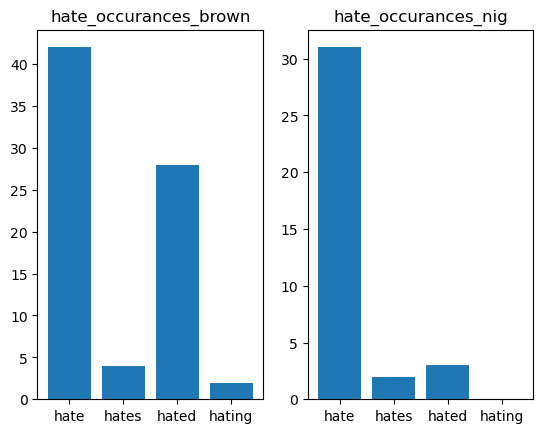

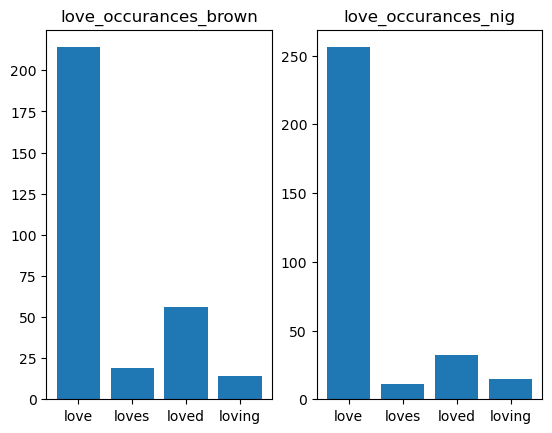

In [3]:
#1

hate_inflections = pyinflect.getAllInflections("hate")
love_inflections = pyinflect.getAllInflections("love")
hate_inflections_words = [x[0] for x in hate_inflections.values()]
love_inflections_words = [x[0] for x in love_inflections.values()]
print("Inflections:", hate_inflections_words, love_inflections_words)

with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    nig_ice_words = nltk.word_tokenize(f.read())
    

hate_occurances_brown, love_occurances_brown, hate_occurances_nig, love_occurances_nig = {}, {}, {}, {}
wordcounts_brown = Counter(brown.words())
wordcounts_nig = Counter(nig_ice_words)
for word in hate_inflections_words:
    hate_occurances_brown[word] = wordcounts_brown[word]
    hate_occurances_nig[word] = wordcounts_nig[word]
for word in love_inflections_words:
    love_occurances_brown[word] = wordcounts_brown[word]
    love_occurances_nig[word] = wordcounts_nig[word]
print("Occurances in brown:", hate_occurances_brown, love_occurances_brown)
print(hate_occurances_nig)
print("Occurances in ice-nig:", hate_occurances_nig, love_occurances_nig)


fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('hate_occurances_brown')
ax1.bar(hate_occurances_brown.keys(), hate_occurances_brown.values())
ax2.title.set_text('hate_occurances_nig')
plt.bar(hate_occurances_nig.keys(), hate_occurances_nig.values())

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text('love_occurances_brown')
ax1.bar(love_occurances_brown.keys(), love_occurances_brown.values())
ax2.title.set_text('love_occurances_nig')
plt.bar(love_occurances_nig.keys(), love_occurances_nig.values())

In [4]:
#2 (this is probably very wrong)

#remove stopwords and words without letters (e.g., "." or ",")
stop_words = set(stopwords.words('english'))
brown_filtered, ice_nig_filtered = [], []
for w in brown.words():
    if not w.lower() in stop_words:
        for c in w:
            if c.isalpha():
                brown_filtered.append(w.lower())
                break

for w in nig_ice_words:
    if not w.lower() in stop_words:
        for c in w:
            if c.isalpha():
                ice_nig_filtered.append(w.lower())
                break

#brown_filtered = [w for w in brown.words() if not w.lower() in stop_words]
#ice_nig_filtered = [w for w in nig_ice_words if not w.lower() in stop_words]

words_to_look_for = hate_inflections_words + love_inflections_words

co_occurring_words_brown = []
for word in words_to_look_for:
    for ngram in nltk.ngrams(brown_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])
    for ngram in nltk.ngrams(brown_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])    
    for ngram in nltk.ngrams(brown_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_brown.append(ngram[i])

co_occurring_words_icenig = []
for word in words_to_look_for:
    for ngram in nltk.ngrams(ice_nig_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
    for ngram in nltk.ngrams(ice_nig_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])    
    for ngram in nltk.ngrams(ice_nig_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    co_occurring_words_icenig.append(ngram[i])
    


wordcounts_brown = Counter(co_occurring_words_brown)
wordcounts_icenig = Counter(co_occurring_words_icenig)
print("top50 wordcounts_brown:", wordcounts_brown.most_common(50), "\n")
print("top50 wordcounts_icenig:", wordcounts_icenig.most_common(50), "\n")

top50 wordcounts_brown: [('god', 105), ('man', 84), ('us', 63), ('one', 62), ('way', 59), ('know', 51), ('much', 49), ('even', 48), ('faith', 45), ('country', 44), ('said', 41), ('world', 41), ('mother', 39), ('little', 39), ('must', 38), ('like', 38), ('could', 36), ("i'd", 36), ('never', 36), ('true', 36), ('johnnie', 36), ('life', 35), ('yet', 35), ('love', 34), ('lost', 32), ('woman', 31), ('give', 30), ("mother's", 30), ('knowledge', 30), ('almost', 30), ('hate', 30), ('always', 30), ('boy', 29), ('fell', 29), ('men', 27), ('another', 27), ('well', 27), ('people', 27), ('fallen', 27), ('girl', 27), ('say', 26), ('children', 26), ('made', 24), ('brethren', 24), ('nature', 24), ('law', 24), ('feel', 23), ('beautiful', 23), ('sincere', 21), ('alive', 21)] 

top50 wordcounts_icenig: [('know', 139), ('people', 114), ('would', 108), ('show', 94), ('god', 91), ("'s", 84), ('erm', 75), ('also', 68), ('reading', 66), ('children', 66), ('much', 62), ('affection', 62), ('say', 60), ('yeah', 

In [5]:
#3

#Extract sentences from ice_nig to same format they are in brown.sents()
ice_nig_sents = []
with open("./ice_nig_combined.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        temp = []
        for word in line.split(" "): 
            temp.append(word.strip("\n"))
        ice_nig_sents.append(temp)
    #print(ice_nig_sents[:20])


most_common_cowords_brown = [x[0] for x in wordcounts_brown.most_common(50)]
most_common_cowords_icenig = [x[0] for x in wordcounts_icenig.most_common(50)]
brown_sentences_hate = []
brown_sentences_love = []
i = 0
for word1 in most_common_cowords_brown:
    print(1, i, 50)
    i += 1
    for word2 in hate_inflections_words:
        for sent in brown.sents():
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in brown_sentences_hate:
                        brown_sentences_hate.append(sent)
print("1 done")
i = 0
for word1 in most_common_cowords_brown:
    print(2, i, 50)
    i += 1
    for word2 in love_inflections_words:
        for sent in brown.sents():
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in brown_sentences_love:
                        brown_sentences_love.append(sent)
print(len(brown_sentences_hate))
print(len(brown_sentences_love))

icenig_sentences_hate = []
icenig_sentences_love = []
i = 0
for word1 in most_common_cowords_icenig:
    print(1, i, 50)
    i += 1
    for word2 in hate_inflections_words:
        for sent in ice_nig_sents:
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in icenig_sentences_hate:
                        icenig_sentences_hate.append(sent)
i = 0
for word1 in most_common_cowords_icenig:
    print(2, i, 50)
    i += 1
    for word2 in love_inflections_words:
        for sent in ice_nig_sents:
            for sent_ngram in nltk.ngrams(sent, 3): #3-grams should also include all 1s and 2s
                if word1 in sent_ngram and word2 in sent_ngram:
                    if sent not in icenig_sentences_love:
                        icenig_sentences_love.append(sent)
print(len(icenig_sentences_hate))
print(len(icenig_sentences_love))

with open("./brown_sentences_hate.txt", "w", encoding="utf-8") as f:
    for item in brown_sentences_hate:
        f.write(" ".join(item) + "\n")
with open("./brown_sentences_love.txt", "w", encoding="utf-8") as f:
    for item in brown_sentences_love:
        f.write(" ".join(item) + "\n")
with open("./icenig_sentences_hate.txt", "w", encoding="utf-8") as f:
    for item in icenig_sentences_hate:
        f.write(" ".join(item) + "\n")
with open("./icenig_sentences_love.txt", "w", encoding="utf-8") as f:
    for item in icenig_sentences_love:
        f.write(" ".join(item) + "\n")

1 0 50
1 1 50
1 2 50
1 3 50
1 4 50
1 5 50
1 6 50
1 7 50
1 8 50
1 9 50
1 10 50
1 11 50
1 12 50
1 13 50
1 14 50
1 15 50
1 16 50
1 17 50
1 18 50
1 19 50
1 20 50
1 21 50
1 22 50
1 23 50
1 24 50
1 25 50
1 26 50
1 27 50
1 28 50
1 29 50
1 30 50
1 31 50
1 32 50
1 33 50
1 34 50
1 35 50
1 36 50
1 37 50
1 38 50
1 39 50
1 40 50
1 41 50
1 42 50
1 43 50
1 44 50
1 45 50
1 46 50
1 47 50
1 48 50
1 49 50
1 done
2 0 50
2 1 50
2 2 50
2 3 50
2 4 50
2 5 50
2 6 50
2 7 50
2 8 50
2 9 50
2 10 50
2 11 50
2 12 50
2 13 50
2 14 50
2 15 50
2 16 50
2 17 50
2 18 50
2 19 50
2 20 50
2 21 50
2 22 50
2 23 50
2 24 50
2 25 50
2 26 50
2 27 50
2 28 50
2 29 50
2 30 50
2 31 50
2 32 50
2 33 50
2 34 50
2 35 50
2 36 50
2 37 50
2 38 50
2 39 50
2 40 50
2 41 50
2 42 50
2 43 50
2 44 50
2 45 50
2 46 50
2 47 50
2 48 50
2 49 50
43
224
1 0 50
1 1 50
1 2 50
1 3 50
1 4 50
1 5 50
1 6 50
1 7 50
1 8 50
1 9 50
1 10 50
1 11 50
1 12 50
1 13 50
1 14 50
1 15 50
1 16 50
1 17 50
1 18 50
1 19 50
1 20 50
1 21 50
1 22 50
1 23 50
1 24 50
1 25 50
1 26 50


In [6]:
#4 Drawing word clouds for all the target words
from wordcloud import WordCloud

hate_co_occurring_words_brown, love_co_occurring_words_brown = "", ""
for word in words_to_look_for:
    for ngram in nltk.ngrams(brown_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    if word in hate_inflections_words:
                        hate_co_occurring_words_brown += ngram[i] + " "
                    else:
                        love_co_occurring_words_brown += ngram[i] + " "
    for ngram in nltk.ngrams(brown_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    if word in hate_inflections_words:
                        hate_co_occurring_words_brown += ngram[i] + " "
                    else:
                        love_co_occurring_words_brown += ngram[i] + " "
    for ngram in nltk.ngrams(brown_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    if word in hate_inflections_words:
                        hate_co_occurring_words_brown += ngram[i] + " "
                    else:
                        love_co_occurring_words_brown += ngram[i] + " "
                    

hate_co_occurring_words_icenig, love_co_occurring_words_icenig = "", ""
for word in words_to_look_for:
    for ngram in nltk.ngrams(ice_nig_filtered, 1):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    if word in hate_inflections_words:
                        hate_co_occurring_words_icenig += ngram[i] + " "
                    else:
                        love_co_occurring_words_icenig += ngram[i] + " "
    for ngram in nltk.ngrams(ice_nig_filtered, 2):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    if word in hate_inflections_words:
                        hate_co_occurring_words_icenig += ngram[i] + " "
                    else:
                        love_co_occurring_words_icenig += ngram[i] + " "
    for ngram in nltk.ngrams(ice_nig_filtered, 3):
        if word in ngram:
            for i in range(len(ngram)):
                if ngram[i] != word:
                    if word in hate_inflections_words:
                        hate_co_occurring_words_icenig += ngram[i] + " "
                    else:
                        love_co_occurring_words_icenig += ngram[i] + " "                   


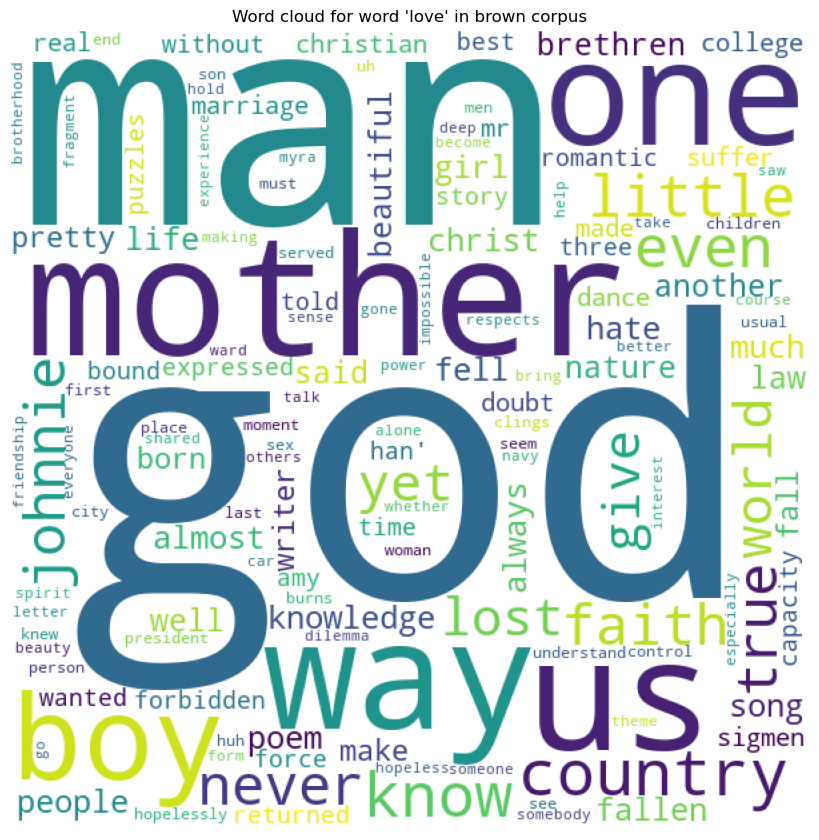

In [7]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(love_co_occurring_words_brown)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'love' in brown corpus")
plt.show()

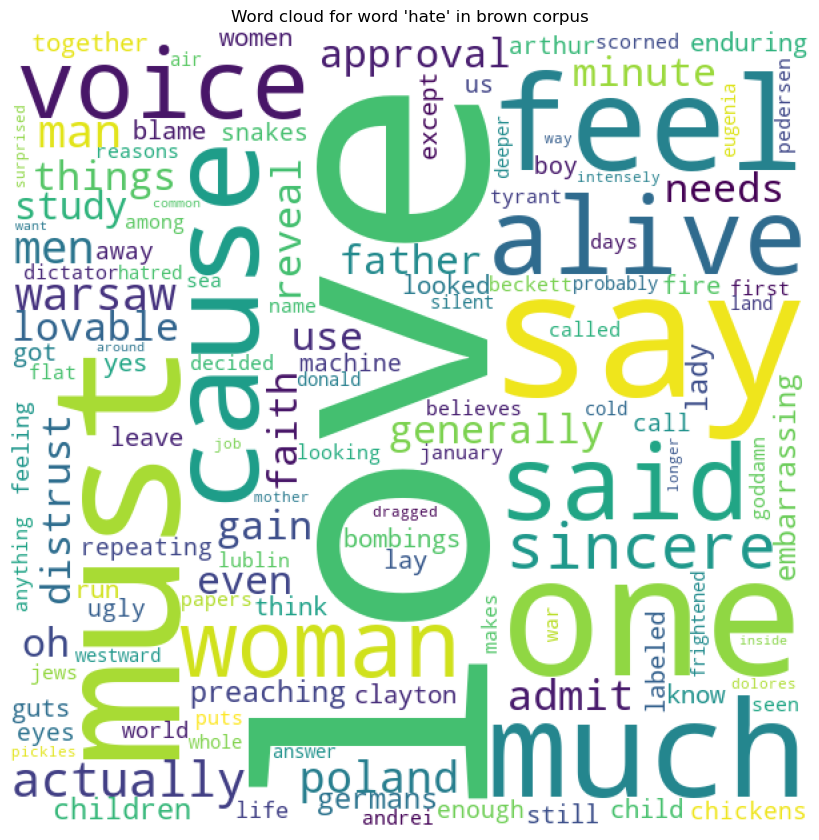

In [8]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(hate_co_occurring_words_brown)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'hate' in brown corpus")
plt.show()

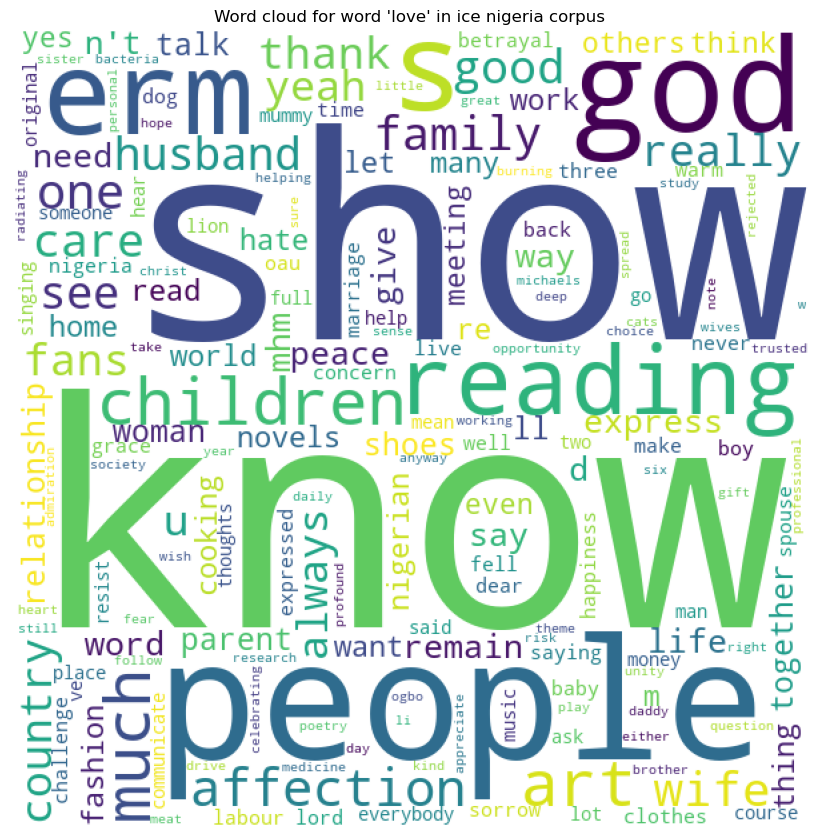

In [9]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(love_co_occurring_words_icenig)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'love' in ice nigeria corpus")
plt.show()

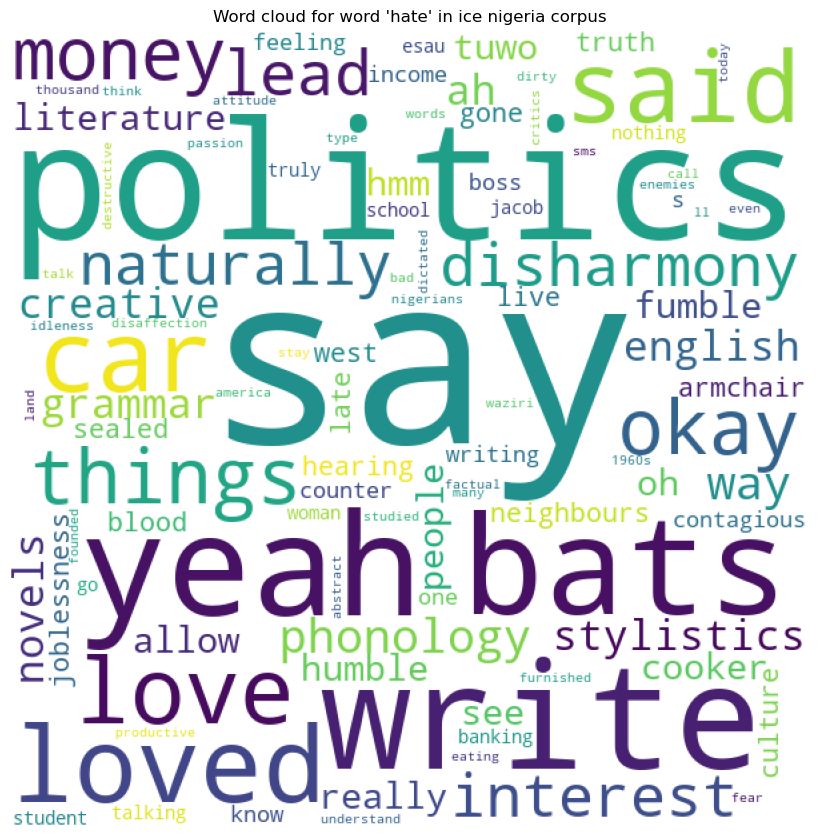

In [10]:
#generate wordcloud
wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                collocations=False,
                min_font_size = 10).generate(hate_co_occurring_words_icenig)

#show plot
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word cloud for word 'hate' in ice nigeria corpus")
plt.show()

In [35]:
#6 The representation is here so it can be called later

#Wordcloud of Top N words in each topic
import matplotlib.colors as mcolors

def topic_representation(LDAmodel, stopWords):
    #colors
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    #create a word cloud
    cloud = WordCloud(stopwords=stopWords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    #get topics
    topics = LDAmodel.show_topics(formatted=False)
    #create figures for 10 topics as 2x5 (2columns, 5rows)
    fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

[(0,
  '0.037*"hate" + 0.037*"irishman" + 0.037*"cause" + 0.037*"graver" + '
  '0.037*"distrust" + 0.003*"man" + 0.003*"conclude" + 0.003*"pin" + '
  '0.003*"young" + 0.003*"newspaper"'),
 (1,
  '0.042*"leave" + 0.019*"say" + 0.015*"hate" + 0.004*"mother" + 0.004*"ugly" '
  '+ 0.004*"man" + 0.004*"come" + 0.004*"love" + 0.004*"run" + 0.004*"make"'),
 (2,
  '0.037*"hate" + 0.037*"show" + 0.037*"reason" + 0.037*"inside" + '
  '0.037*"woman" + 0.003*"man" + 0.003*"frenzy" + 0.003*"enemy" + '
  '0.003*"young" + 0.003*"newspaper"'),
 (3,
  '0.144*"hate" + 0.034*"love" + 0.023*"think" + 0.023*"come" + 0.023*"eat" + '
  '0.012*"ugly" + 0.012*"man" + 0.012*"mother" + 0.012*"kill" + 0.012*"feel"'),
 (4,
  '0.051*"hate" + 0.035*"endure" + 0.035*"pity" + 0.018*"effect" + '
  '0.018*"experience" + 0.018*"wide" + 0.018*"last" + 0.018*"manage" + '
  '0.018*"envy" + 0.018*"control"'),
 (5,
  '0.079*"hate" + 0.023*"assignment" + 0.012*"say" + 0.012*"woman" + '
  '0.012*"leave" + 0.012*"voice" + 0.012*

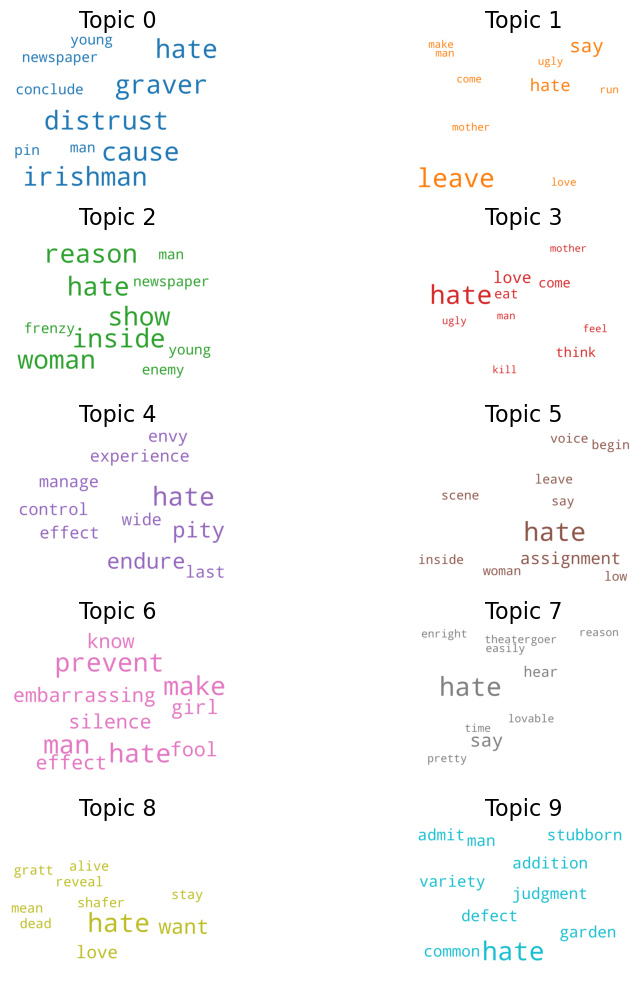

[(0,
  '0.055*"love" + 0.026*"child" + 0.024*"marriage" + 0.020*"professional" + '
  '0.019*"voice" + 0.017*"hear" + 0.017*"impossible" + 0.016*"do" + '
  '0.016*"prefer" + 0.014*"darkness"'),
 (1,
  '0.029*"beautiful" + 0.025*"design" + 0.024*"love" + 0.020*"classical" + '
  '0.020*"timeless" + 0.020*"attractive" + 0.020*"carefully" + 0.020*"garson" '
  '+ 0.020*"clothe" + 0.020*"greer"'),
 (2,
  '0.054*"love" + 0.023*"else" + 0.021*"kind" + 0.016*"woman" + 0.015*"guy" + '
  '0.015*"well" + 0.014*"lose" + 0.012*"come" + 0.012*"bear" + 0.012*"give"'),
 (3,
  '0.059*"love" + 0.020*"never" + 0.018*"period" + 0.018*"town" + '
  '0.018*"advice" + 0.017*"real" + 0.017*"gift" + 0.017*"freedom" + 0.016*"go" '
  '+ 0.015*"wrong"'),
 (4,
  '0.053*"love" + 0.032*"always" + 0.029*"really" + 0.023*"story" + '
  '0.022*"want" + 0.019*"person" + 0.018*"take" + 0.017*"way" + 0.015*"middle" '
  '+ 0.014*"try"'),
 (5,
  '0.036*"love" + 0.032*"call" + 0.031*"recent" + 0.023*"give" + 0.020*"ever" '
  '+ 

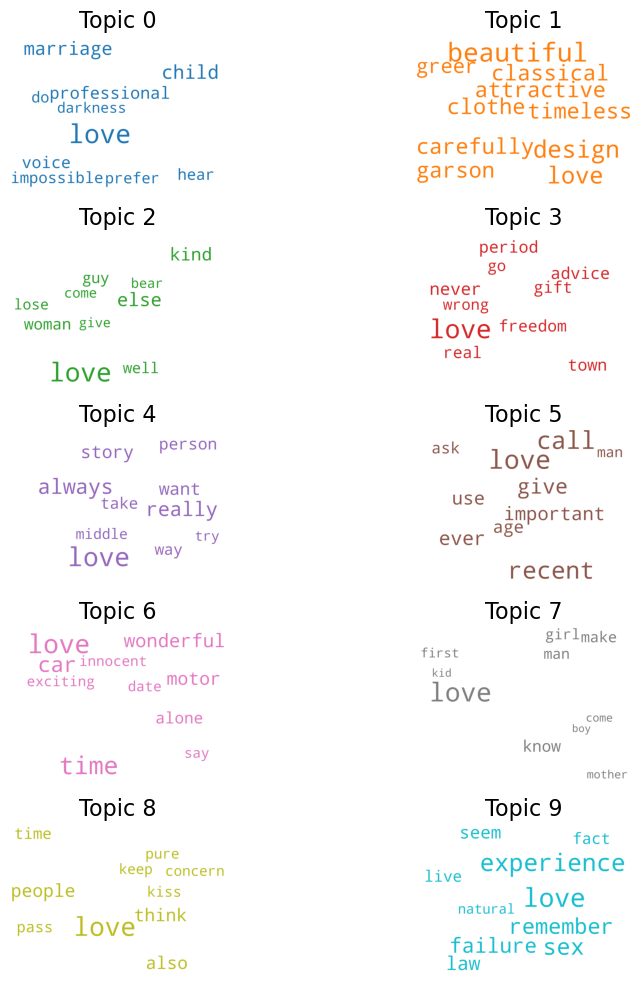

[(0,
  '0.235*"say" + 0.159*"hate" + 0.083*"live" + 0.083*"furnish" + 0.083*"flat" '
  '+ 0.083*"car" + 0.083*"great" + 0.083*"bank" + 0.008*"politic" + '
  '0.008*"love"'),
 (1,
  '0.045*"hate" + 0.045*"say" + 0.045*"politic" + 0.045*"love" + 0.045*"see" + '
  '0.045*"woman" + 0.045*"furnish" + 0.045*"great" + 0.045*"live" + '
  '0.045*"respond"'),
 (2,
  '0.212*"politic" + 0.212*"see" + 0.212*"hate" + 0.019*"say" + 0.019*"love" + '
  '0.019*"great" + 0.019*"car" + 0.019*"live" + 0.019*"furnish" + '
  '0.019*"bank"'),
 (3,
  '0.172*"politic" + 0.172*"talk" + 0.090*"believe" + 0.090*"liar" + '
  '0.090*"people" + 0.090*"analyst" + 0.090*"even" + 0.090*"hate" + '
  '0.008*"say" + 0.008*"love"'),
 (4,
  '0.045*"hate" + 0.045*"politic" + 0.045*"say" + 0.045*"love" + 0.045*"see" + '
  '0.045*"great" + 0.045*"worldly" + 0.045*"talk" + 0.045*"furnish" + '
  '0.045*"woman"'),
 (5,
  '0.262*"politic" + 0.262*"hate" + 0.024*"say" + 0.024*"love" + 0.024*"see" + '
  '0.024*"live" + 0.024*"woman" 

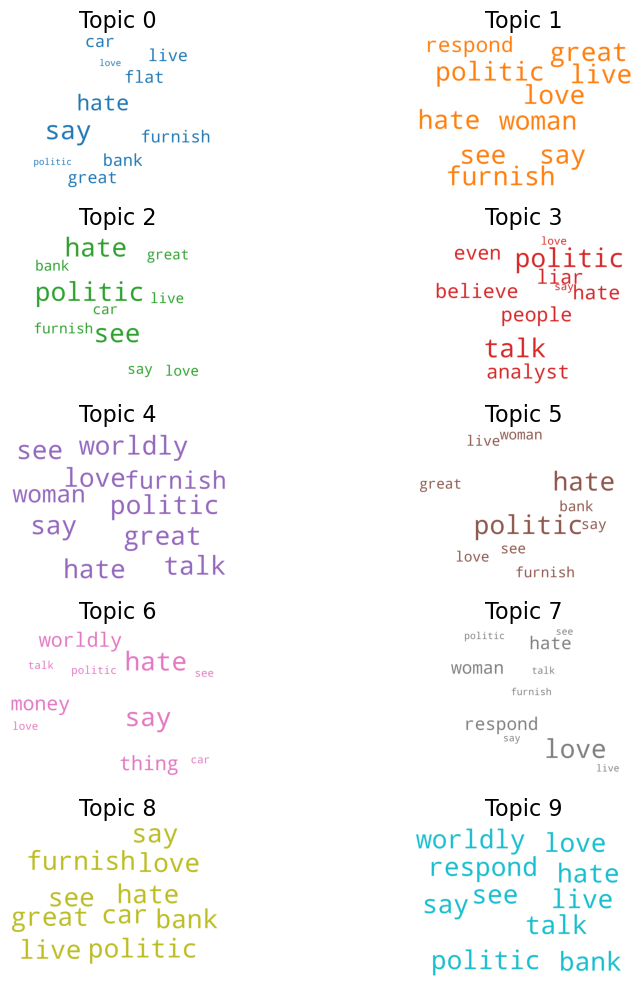

[(0,
  '0.045*"love" + 0.030*"gift" + 0.029*"know" + 0.013*"see" + 0.011*"wrap" + '
  '0.010*"wrapping" + 0.009*"go" + 0.009*"use" + 0.008*"come" + 0.007*"sugar"'),
 (1,
  '0.011*"know" + 0.011*"people" + 0.010*"state" + 0.010*"go" + 0.009*"make" + '
  '0.008*"say" + 0.007*"use" + 0.007*"nigerian" + 0.006*"country" + '
  '0.006*"erm"'),
 (2,
  '0.025*"know" + 0.017*"say" + 0.017*"test" + 0.017*"thing" + 0.014*"use" + '
  '0.013*"talk" + 0.012*"learn" + 0.011*"go" + 0.011*"erm" + 0.010*"want"'),
 (3,
  '0.002*"love" + 0.002*"family" + 0.002*"together" + 0.002*"stadium" + '
  '0.002*"esuene" + 0.002*"bind" + 0.002*"stuff" + 0.001*"fan" + 0.001*"know" '
  '+ 0.001*"erm"'),
 (4,
  '0.004*"love" + 0.002*"also" + 0.002*"help" + 0.002*"like" + 0.002*"oluremi" '
  '+ 0.002*"enderly" + 0.002*"art" + 0.002*"one" + 0.001*"know" + 0.001*"say"'),
 (5,
  '0.004*"express" + 0.002*"point" + 0.002*"wrong" + 0.002*"wear" + '
  '0.002*"comfortable" + 0.002*"beyonce" + 0.002*"bible" + 0.002*"love" + '
  '

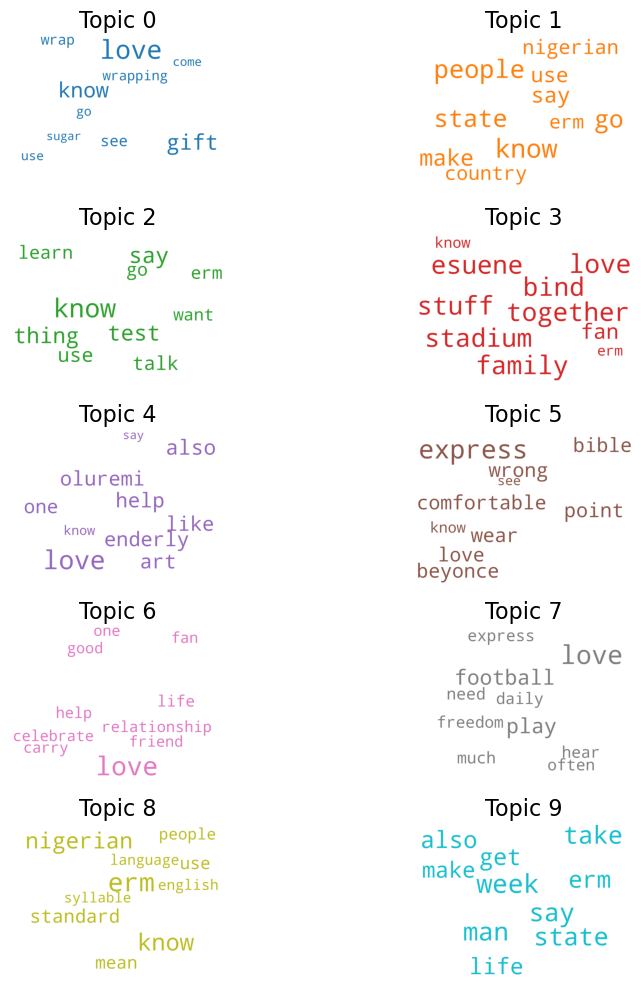

In [36]:
#5
# opening the file in read mode
#my_file = open("ice_nig_combined.txt", "r", encoding="utf-8")
  
# reading the file
#data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
#data_into_list = data.replace('\n', ' ').split(".")
                              
#def sent_to_words(sentences):
#    for sentence in sentences:
#        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

#data_words = list(sent_to_words(data_into_list))
#brown_sentences_hate
#brown_sentences_love
#icenig_sentences_hate
#icenig_sentences_love

alldocuments = [brown_sentences_hate, brown_sentences_love, icenig_sentences_hate, icenig_sentences_love]

def LDA_implementation(data_words):

    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    nlp.max_length = 1031272

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]


    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    return lda_model, corpus

for sentences in alldocuments:
    LDA_model, corpus = LDA_implementation(sentences)
    pprint(LDA_model.print_topics())
    topic_representation(LDA_model, stop_words)
#doc_lda = lda_model[corpus]

In [38]:
#7
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
text_brown_sentences_hate = ""
with open("./brown_sentences_hate.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_brown_sentences_hate += line
sentiment_brown_sentences_hate = SentimentIntensityAnalyzer().polarity_scores(text_brown_sentences_hate)

text_brown_sentences_love = ""
with open("./brown_sentences_love.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_brown_sentences_love += line
sentiment_brown_sentences_love = SentimentIntensityAnalyzer().polarity_scores(text_brown_sentences_love)

text_icenig_sentences_hate = ""
with open("./icenig_sentences_hate.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_icenig_sentences_hate += line
sentiment_icenig_sentences_hate = SentimentIntensityAnalyzer().polarity_scores(text_icenig_sentences_hate)

text_icenig_sentences_love = ""
with open("./icenig_sentences_love.txt", "r", encoding="utf-8") as f:
    for line in f.readlines():
        text_icenig_sentences_love += line
sentiment_icenig_sentences_love = SentimentIntensityAnalyzer().polarity_scores(text_icenig_sentences_love)

print("brown_sentences_hate.txt - Polarity scores:{}".format(sentiment_brown_sentences_hate))
print("brown_sentences_love.txt - Polarity scores:{}".format(sentiment_brown_sentences_love))
print("icenig_sentences_hate.txt - Polarity scores:{}".format(sentiment_icenig_sentences_hate))
print("icenig_sentences_love.txt - Polarity scores:{}".format(sentiment_icenig_sentences_love))

brown_sentences_hate.txt - Polarity scores:{'neg': 0.258, 'neu': 0.643, 'pos': 0.099, 'compound': -0.9997}
brown_sentences_love.txt - Polarity scores:{'neg': 0.07, 'neu': 0.667, 'pos': 0.262, 'compound': 1.0}
icenig_sentences_hate.txt - Polarity scores:{'neg': 0.16, 'neu': 0.613, 'pos': 0.227, 'compound': 0.8481}
icenig_sentences_love.txt - Polarity scores:{'neg': 0.051, 'neu': 0.802, 'pos': 0.147, 'compound': 1.0}
